In [181]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from wmfdata import hive
from wmfdata.charting import set_mpl_style
from wmfdata.utils import pd_display_all

In [182]:
set_mpl_style()

def plot_df(df):
    ax = df.plot.area()
    ylim = plt.ylim()
    plt.ylim((ylim[0], ylim[1] * 1.1))

In [187]:
CHART_START = "2018-07"
CHART_END = "2019-11-11"
TARGET_WIKIS = ("mlwiki", "bnwiki", "tlwiki", "jvwiki", "mnwiki")
ISO_DT_FMT = "%Y-%m-%dT%H:%M:%SZ"

time_range = pd.period_range(CHART_START, CHART_END, freq="W-SUN")
time_end = (time_range[-1] + 1).to_timestamp(how="start")

# If the last week goes past the end of mediawiki_history, remove it
if time_end > pd.Timestamp(CHART_END):
    time_range = time_range[:-1]
    time_start = time_range[0].to_timestamp(how="start").strftime(ISO_DT_FMT)
    time_end = (time_range[-1] + 1).to_timestamp(how="start").strftime(ISO_DT_FMT)
    
query_params = {
    "time_start": time_start,
    "time_end": time_end,
    "target_wikis": TARGET_WIKIS
}

In [ ]:
translations = hive.run("""
select
    substr(rtc.meta.dt, 0, 10) as date,
    rtc.`database` as wiki,
    page_title as title,
    rtc.performer.user_text as translator,
    -- The SSAC Hive table goes back to 2017-11-28, so previous global registrations will be null
    substr(ssac.dt, 0, 10) as translator_global_registration,
    substr(rtc.performer.user_registration_dt, 0, 10) as translator_local_registration,
    rtc.performer.user_edit_count as translator_local_edits
from event.mediawiki_revision_tags_change rtc
left join event_sanitized.serversideaccountcreation ssac
on
    ssac.event.username = performer.user_text and
    ssac.year >= 0
where
    rtc.meta.dt between "{time_start}" and "{time_end}" and
    array_contains(rtc.tags, "contenttranslation") and
    (rtc.year = 2018 and rtc.month >= 7 or rtc.year = 2019)
""".format(**query_params)
).assign(
    date=lambda df: pd.to_datetime(df["date"]),
    translator_global_registration=lambda df: pd.to_datetime(df["translator_global_registration"]),
    translator_local_registration=lambda df: pd.to_datetime(df["translator_local_registration"])
).assign(
    week=lambda df: df["date"].dt.to_period("W-SUN").dt.to_timestamp(),
    translator_global_tenure=lambda df: df["date"] - df["translator_global_registration"],
    translator_local_tenure=lambda df: df["date"] - df["translator_local_registration"]
)

In [272]:
mo_6 = pd.Timedelta(180, unit="days")
tenure_group = lambda ser: np.where(ser < mo_6, "less than 6 months", "6 months or more")
  
translators = translations.assign(
  global_tenure_group=lambda df: tenure_group(df["translator_global_tenure"]),
  local_tenure_group=lambda df: tenure_group(df["translator_local_tenure"])
)

# Newcomer translations drop

Based on global registration dates, translations by newcomers have dropped substantially.

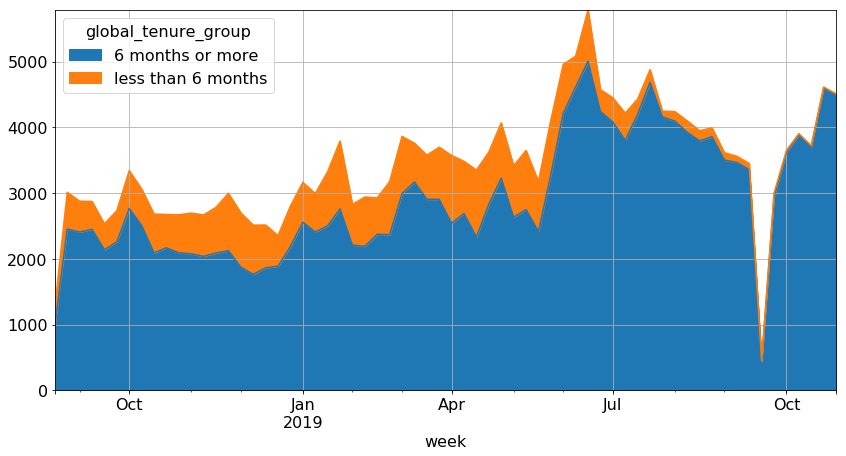

In [284]:
(
  translators
  .groupby(["week", "global_tenure_group"])
  .size()
  .unstack()
  .plot.area()
)

But that doesn't seem to be true when using local registration dates, and in any case overall translations haven't dropped.

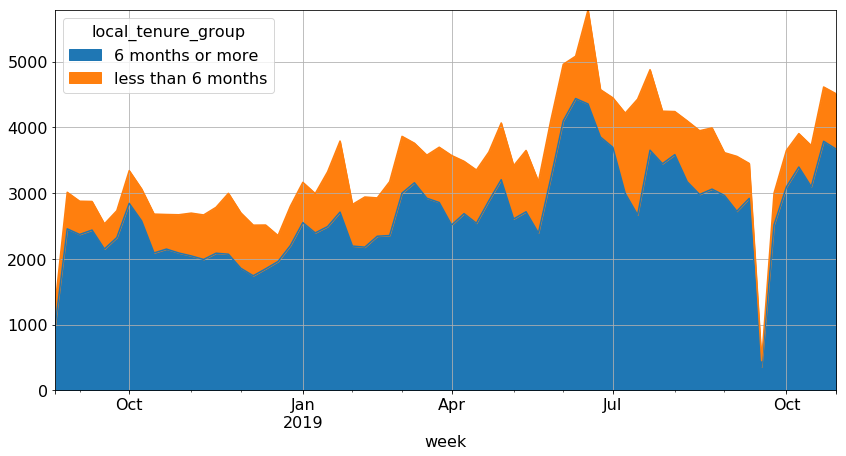

In [285]:
(
  translators
  .groupby(["week", "local_tenure_group"])
  .size()
  .unstack()
  .plot.area()
)

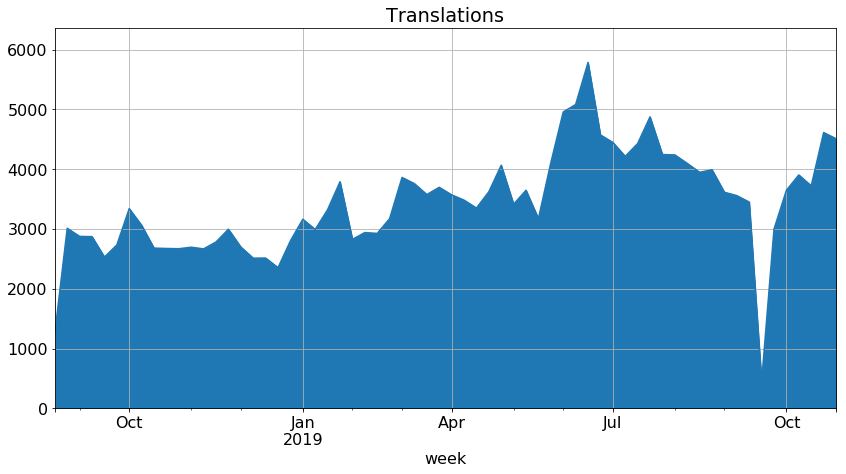

In [302]:
weekly_translations = (
    translations
    .groupby(['week'])
    .size()
)

plot_df(weekly_translations)
plt.title('Translations');

There seem to be a lot of translators with recent local registration dates but null global registration dates. The data stream I used for global registrations only goes back to 2017-11-28, but shouldn't have any gaps for newer registrations.

In [254]:
d_100 = pd.Timedelta(100, unit="days")
translations.query("translator_local_tenure < @d_100 & translator_global_tenure.isnull()").sample(10)

,date,wiki,title,translator,translator_global_registration,translator_local_registration,translator_local_edits,translator_global_tenure,translator_local_tenure,week
96052,2019-08-22,viwiki,Gối_chỉnh_hình,Faipuzi,NaT,2019-08-22,1,NaT,0 days,2019-08-19
47982,2019-09-14,zhwiki,马来西亚伊斯兰银行,500000000006城,NaT,2019-08-06,60,NaT,39 days,2019-09-09
33283,2019-10-24,enwiki,User:Uriahsm/עידו_מרקוס,Uriahsm,NaT,2019-09-22,0,NaT,32 days,2019-10-21
32558,2019-08-22,viwiki,Prucalopride,Ptthnhan,NaT,2019-06-17,3196,NaT,66 days,2019-08-19
162624,2019-06-07,enwiki,Bryan,Eric860124,NaT,2019-06-07,0,NaT,0 days,2019-06-03
32515,2019-08-25,viwiki,Terbutaline,Ptthnhan,NaT,2019-06-17,3460,NaT,69 days,2019-08-19
110927,2018-09-30,satwiki,ᱨᱮᱝᱜᱟᱞᱤ_ᱰᱮᱢ,Ramjit Tudu,NaT,2018-08-04,547,NaT,57 days,2018-09-24
32173,2019-06-30,viwiki,Ciclobendazole,Ptthnhan,NaT,2019-06-17,768,NaT,13 days,2019-06-24
32175,2019-06-30,viwiki,Tiabendazole,Ptthnhan,NaT,2019-06-17,765,NaT,13 days,2019-06-24
54661,2019-08-22,bswiki,Duki,Mauro Joan,NaT,2019-08-22,0,NaT,0 days,2019-08-19


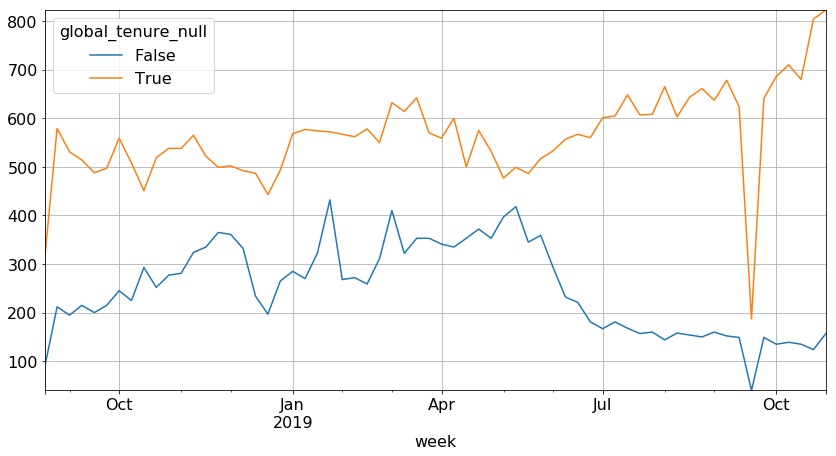

In [222]:
(
  translations
  .assign(global_tenure_null=lambda df: df["translator_global_tenure"].isnull())
  .groupby(["week", "global_tenure_null"])
  .nunique()["translator"]
  .unstack()
  .plot()
)

In [266]:
ssac_daily = hive.run("""
SELECT
  CONCAT_WS("-", CAST(year AS STRING), LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  if(event.userName IS NULL, "null", "not null") as user_name_status,
  COUNT(*) as registrations
FROM event_sanitized.serversideaccountcreation
WHERE
  year > 0
GROUP BY
  year, month, day,
  event.userName IS NULL
""").assign(date=lambda df: pd.to_datetime(df["date"]))

Aaaand it turns out that the [ServerSideAccountCreation](https://meta.wikimedia.org/wiki/Schema:ServerSideAccountCreation) is the problem: during the beginning of June 2019, the username field went null, probably because the instrumentation in MediaWiki got broken. That meant that my query didn't find users who registered afterwards in the data stream and incorrectly decided they must have registered before the start of the stream.

In [299]:
ssac_weekly = (
  ssac_daily
  .assign(week=lambda df: df["date"].dt.to_period("W-SUN").dt.to_timestamp())
  .groupby(["week", "user_name_status"])
  .sum()["registrations"]
  .unstack()
  .fillna(0)
  [1:-1] # Trim partial weeks at start and end
)

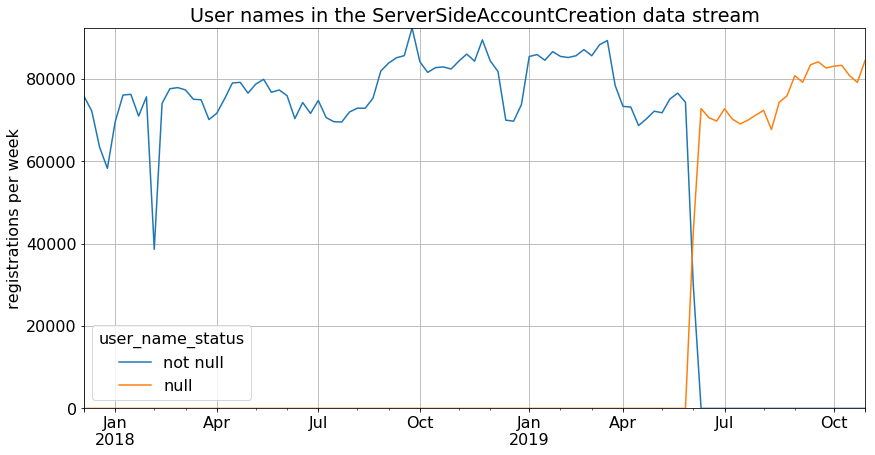

In [301]:
ssac_weekly.plot(ylim=0)

plt.xlabel(None)
plt.ylabel("registrations per week")
plt.title("User names in the ServerSideAccountCreation data stream");

# Target wiki translations

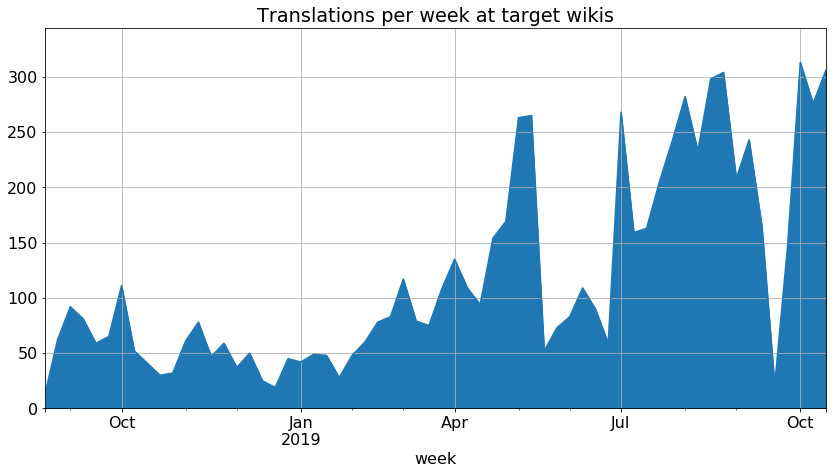

In [133]:
weekly_target_wiki_translations = (
    translations.query("wiki in @TARGET_WIKIS")
    .groupby("week")
    .size()
)

plot_df(weekly_target_wiki_translations)
plt.title("Translations per week at target wikis");

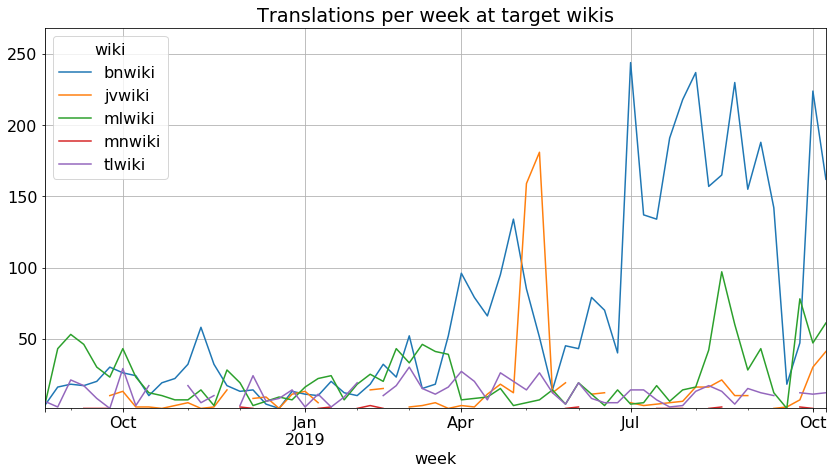

In [123]:
def plot_df(df):
    ax = df.plot.line()
    ylim = plt.ylim()
    plt.ylim((ylim[0], ylim[1] * 1.1))

weekly_target_wiki_translations_by_wiki = (
    target_wiki_translations
    .groupby(["week", "wiki"])
    .size()
    .unstack()
)

plot_df(weekly_target_wiki_translations_by_wiki)
plt.title("Translations per week at target wikis");

In [304]:
prev_q1_translations = target_wiki_translations.query("week >= '2018-07-02' and week < '2019-10-01'")
prev_q3_translations = target_wiki_translations.query("week >= '2018-12-31' and week < '2019-04-01'")
prev_q4_translations = target_wiki_translations.query("week >= '2019-04-01' and week < '2019-07-01'")
cur_q1_translations = target_wiki_translations.query("week >= '2019-07-01' and week < '2019-09-30'")

In [308]:
def weekly_translations(quarter_series):
  return len(quarter_series) / quarter_series["week"].nunique()
  
prev_q1_rate = weekly_translations(prev_q1_translations)
prev_q3_rate = weekly_translations(prev_q3_translations)
prev_q4_rate = weekly_translations(prev_q4_translations)
cur_q1_rate = weekly_translations(cur_q1_translations)

In [309]:
prev_q1_rate

109.57627118644068

In [310]:
prev_q3_rate

66.15384615384616

In [311]:
prev_q4_rate

127.3076923076923

In [312]:
cur_q1_rate

214.69230769230768

In [83]:
new_content = hive.run("""
select
    `database` as wiki,
    substr(meta.dt, 0, 10) as date,
    count(*) as new_articles
from event.mediawiki_page_create
where
    meta.dt between "{time_start}" and "{time_end}" and
    `database` in {target_wikis} and 
    page_namespace = 0 and
    not page_is_redirect and
    year >= 2019
group by `database`, substr(meta.dt, 0, 10)
""".format(**query_params)
).assign(
    date=lambda df: pd.to_datetime(df["date"])
).assign(
    week=lambda df: df["date"].dt.to_period("W-MON").dt.to_timestamp()
)

In [92]:
weekly_new_content = (
    new_content
    .pivot_table(values="new_articles", index="week", columns="wiki", aggfunc="sum")
    .fillna(0)
    .sum(axis=1)
)

In [313]:
cur_q1_new_content = weekly_new_content['2019-07-01':'2019-09-30']

# Weekly new content rate
cur_q1_new_content.sum() / len(q1_new_content)

766.5384615384615